# Style Time Evaluation.
This script will evaluate Style Time As the Paper do.

### Import and Functions

In [ ]:
import os 
os.environ["VISIBLE_DEVICES"] = ''

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

2024-12-19 16:54:25.499009: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-19 16:54:25.513178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734623665.529943 3005864 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734623665.535010 3005864 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 16:54:25.552380: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
from tensorflow.python.keras.metrics import MeanAbsoluteError


# def lstm_model(seq_shape:tuple) -> tf.keras.Model:
#     """Make the LSTM Model as stated in the paper (2x100 lstm layers.)

#     Args:
#         seq_shape (tuple): The Shape of the sequence.

#     Returns:
#         tf.keras.Model: The model.
#     """
    
#     model = tf.keras.Sequential()
#     print(seq_shape)
#     model.add(tf.keras.layers.Input(seq_shape))
#     model.add(tf.keras.layers.Reshape((seq_shape[-1], seq_shape[-2])))
    
#     model.add(tf.keras.layers.LSTM(100, return_sequences=True))
#     # model.add(tf.keras.layers.RepeatVector(seq_shape[-1]))
#     model.add(tf.keras.layers.LSTM(100, return_sequences=True))
    
#     model.add(
#         tf.keras.layers.TimeDistributed(
#             tf.keras.layers.Dense(seq_shape[0])
#         )
#     )
    
#     model.add(tf.keras.layers.Reshape(seq_shape))
    
#     model.compile(
#         optimizer='Adam', 
#         loss="mae", 
#         metrics=[MeanAbsoluteError()]
#     )
    
#     return model


def lstm_model(seq_shape:tuple) -> tf.keras.Model:
    """Make the LSTM Model as stated in the paper (2x100 lstm layers.)

    Args:
        seq_shape (tuple): The Shape of the sequence.

    Returns:
        tf.keras.Model: The model.
    """
    
    
    _in = tf.keras.layers.Input(seq_shape)
    
    x = tf.keras.layers.Reshape((seq_shape[-1], seq_shape[-2]))(_in)
    
    x= tf.keras.layers.LSTM(100, return_sequences=True)(x)
    
    x = tf.keras.layers.Flatten()(x)
    
    x = tf.keras.layers.Dense(50)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.RepeatVector(seq_shape[-1])(x)
    
    x= tf.keras.layers.LSTM(100, return_sequences=True)(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(seq_shape[0]))(x)
    
    _out = tf.keras.layers.Reshape(seq_shape)(x)
    
    model = tf.keras.Model(_in, _out)
    
    model.compile(
        optimizer='adam', 
        loss="mae", 
        metrics=[MeanAbsoluteError()]
    )
    
    return model



In [3]:
def plot_learning_curves(hist):
    plt.figure(figsize=(10, 5))
    
    plt.plot(hist.history['loss'], '.-', label=" Train Loss")
    plt.plot(hist.history['val_loss'], '.-', label="Valid Loss")
    
    plt.grid()
    plt.show()

def train_model(train_dset:np.ndarray, valid_dset:np.ndarray, epochs=50) -> tf.keras.Model:
    model = lstm_model(train_dset.shape[1:])
    
    hist = model.fit(train_dset, train_dset, validation_data=(valid_dset, valid_dset), epochs=epochs)
    
    plot_learning_curves(hist)
    
    return model

In [4]:
def evaluate_model(model:tf.keras.Model, test_dataset:np.ndarray)-> float:
    reconstructions = model(test_dataset)
    mae = tf.keras.metrics.MeanAbsoluteError()
    return mae(test_dataset, reconstructions).numpy()
    
    # return np.mean((np.sum(np.abs(reconstructions - test_dataset), axis=-1)))

## GOOGLE STOCKS RESULTS.
### TSTR MAE on "In Sample" Dataset.

In this part, we train the model on the "style transfered" data. Then, we evaluate it on the real data.

In [ ]:
in_sample_train = np.load("data/google_stocks/preprocessed/style_train.npy")
in_sample_test = np.load("data/google_stocks/preprocessed/style_test.npy")

transfered_in_samples_train = np.load("data/google_stocks/preprocessed/in_sample_train_transfered.npy")
transfered_in_samples_test = np.load("data/google_stocks/preprocessed/in_sample_test_transfered.npy")

# in_sample_trained_model = train_model(transfered_in_samples_train, in_sample_test, epochs=100)
in_sample_trained_model = train_model(transfered_in_samples_train, transfered_in_samples_test, epochs=300)

I0000 00:00:1734622774.442392 3005235 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20438 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:2d:00.0, compute capability: 8.6


Epoch 1/300


I0000 00:00:1734622778.926359 3005528 cuda_dnn.cc:529] Loaded cuDNN version 90300


30/80 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2604 - mean_absolute_error: 0.3538

#### plot some sequences

In [6]:
def plot_reconstruction(model, sequence, title=""):
    model_reconstruction = model(np.array([sequence]))[0]
    plt.figure(figsize=(10, 5))

    ax = plt.subplot(111)
    ax.set_title(title)
    ax.plot(sequence[0], ".-", label='model True')
    ax.grid(True)

    ax.plot(model_reconstruction[0], ".-", label='model Reconstruction')

    ax.grid(True)
    ax.legend()
    plt.show()


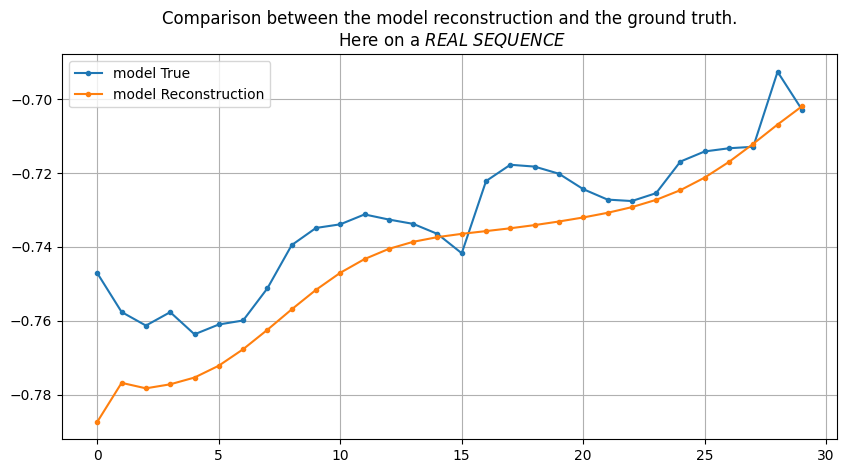

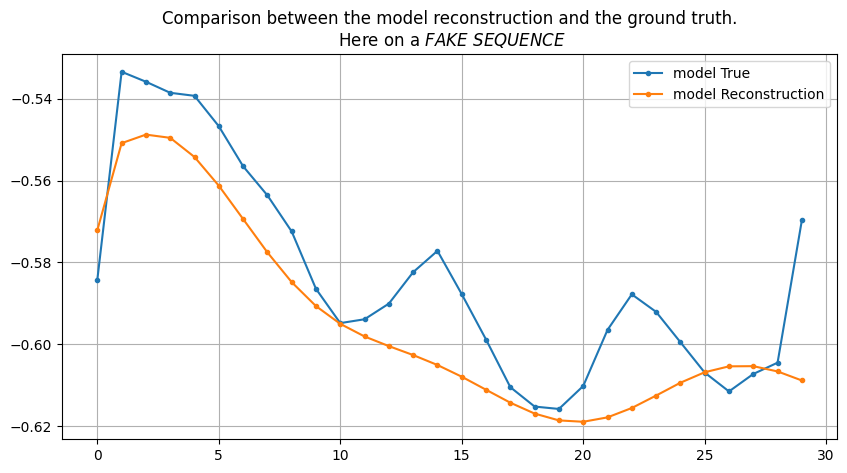

In [ ]:
plot_reconstruction(
    in_sample_trained_model, 
    in_sample_test[0],
    "Comparison between the model reconstruction and the ground truth.\n Here on a $REAL$ $SEQUENCE$")

plot_reconstruction(
    in_sample_trained_model, 
    transfered_in_samples_test[0],
    "Comparison between the model reconstruction and the ground truth.\n Here on a $FAKE$ $SEQUENCE$")

#### Evaluate the model 
With the Metric paper's metric: MAE

In [ ]:
in_sample_model_real_mae = evaluate_model(in_sample_trained_model, in_sample_test)
in_sample_model_fake_mae = evaluate_model(in_sample_trained_model, transfered_in_samples_test)

in_sample_model_real_mae, in_sample_model_fake_mae

(np.float32(0.016462661), np.float32(0.01599859))

### Test on "Perturbed" Dataset.

Epoch 1/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.1986 - mean_absolute_error: 0.2779 - val_loss: 0.0938 - val_mean_absolute_error: 0.1269
Epoch 2/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0900 - mean_absolute_error: 0.1174 - val_loss: 0.0797 - val_mean_absolute_error: 0.1054
Epoch 3/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0735 - mean_absolute_error: 0.1012 - val_loss: 0.0643 - val_mean_absolute_error: 0.0937
Epoch 4/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0629 - mean_absolute_error: 0.0907 - val_loss: 0.0511 - val_mean_absolute_error: 0.0850
Epoch 5/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0515 - mean_absolute_error: 0.0824 - val_loss: 0.0525 - val_mean_absolute_error: 0.0782
Epoch 6/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0515 - mean_absolute_error: 0.0766 - val_loss: 0.0455 - val_mean_absolute_error: 0.0736
Epoch 7/300
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0489 - mean_absolute_error: 0.0722 - v

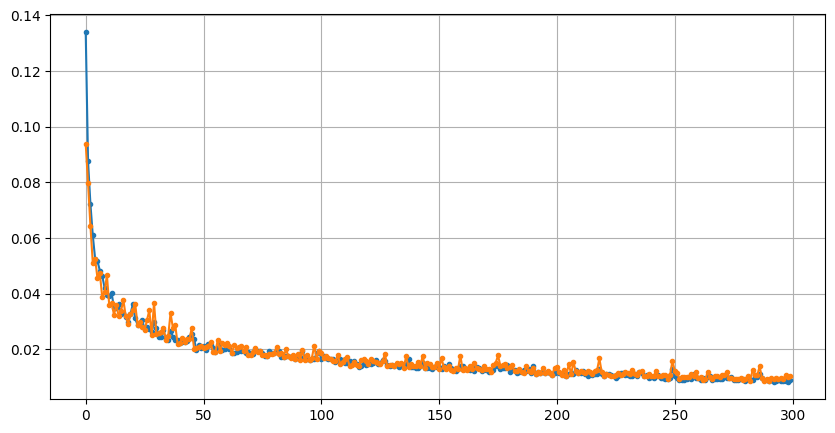

In [ ]:
perturbed_generated_train = np.load("data/google_stocks/preprocessed/perturbed_train_transfered.npy")
perturbed_generated_test = np.load("data/google_stocks/preprocessed/perturbed_test_transfered.npy")

perturbed_trained_model = train_model(perturbed_generated_train, perturbed_generated_test, epochs=300)

#### Plot Reconstructions

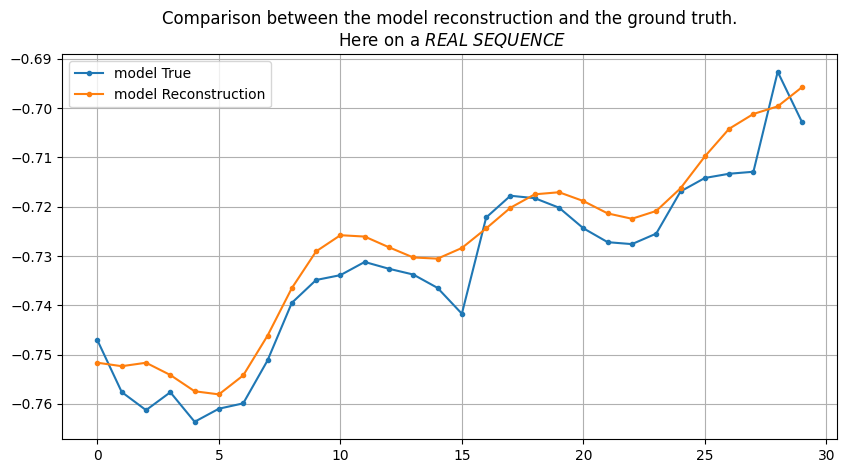

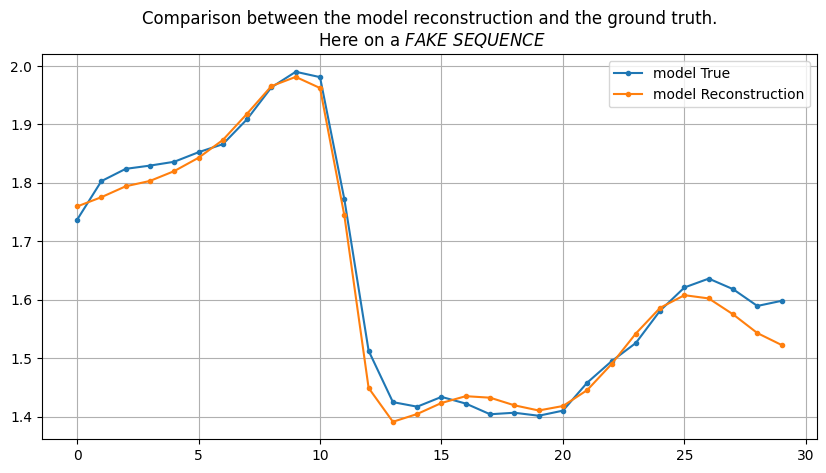

In [ ]:
plot_reconstruction(
    perturbed_trained_model, 
    in_sample_test[0],
    "Comparison between the model reconstruction and the ground truth.\n Here on a $REAL$ $SEQUENCE$")

plot_reconstruction(
    perturbed_trained_model, 
    perturbed_generated_test[0],
    "Comparison between the model reconstruction and the ground truth.\n Here on a $FAKE$ $SEQUENCE$")

#### Evaluate the model

In [ ]:
perturbed_model_real_mae = evaluate_model(perturbed_trained_model, in_sample_test)
perturbed_model_fake_mae = evaluate_model(perturbed_trained_model, perturbed_generated_test)

perturbed_model_real_mae, perturbed_model_fake_mae

(np.float32(0.009334899), np.float32(0.010269043))

### Make the Precision Recall

In [12]:
def make_embedding(model:tf.keras.models.Model, dataset:np.ndarray):
    _out = model.layers[4].output
    embeder = tf.keras.Model(model.input, _out)
    
    embeddings = [tf.reshape(embeder(np.array([d])), -1) for d in dataset]
    
    return np.array(embeddings)

def get_f1(precision, recall):
    return np.mean(2 * (precision * recall)/(precision + recall))
    
    
is_real_emb = make_embedding(in_sample_trained_model, in_sample_test)

is_fake_emb = make_embedding(in_sample_trained_model, transfered_in_samples_test)

pert_fake_emb = make_embedding(in_sample_trained_model, perturbed_generated_test)


In [ ]:
from src.eval import prd

in_sample_precision, in_sample_recall = prd.compute_prd_from_embedding(is_real_emb, is_fake_emb)
in_sample_f1 = get_f1(in_sample_precision, in_sample_recall)

pert_precision, pert_recall = prd.compute_prd_from_embedding(is_real_emb, pert_fake_emb)
pert_f1 = get_f1(pert_precision, pert_recall)

pert_f1

np.float64(0.5284740781964868)

#### Generate a DataFrame with the results.

In [14]:
values = np.array([[in_sample_model_real_mae, in_sample_f1],  [perturbed_model_real_mae, pert_f1]])
# values = 1- values
cols = ["Google Stocks TSTR MAE", "Google Stocks F1"]
index = ["Style Time (In Samples)", "Style Time (Perturbed)"]

google_stocks_results = pd.DataFrame(index=index, columns=cols, data=values)

google_stocks_results

,Google Stocks TSTR MAE,Google Stocks F1
Style Time (In Samples),0.016463,0.555823
Style Time (Perturbed),0.009335,0.528474


## Energy Dataset
### Again, TSTR MAE on "In Sample" Dataset

Epoch 1/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.3518 - mean_absolute_error: 0.3795 - val_loss: 0.2902 - val_mean_absolute_error: 0.3109
Epoch 2/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.2737 - mean_absolute_error: 0.3016 - val_loss: 0.2478 - val_mean_absolute_error: 0.2848
Epoch 3/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.2418 - mean_absolute_error: 0.2778 - val_loss: 0.2239 - val_mean_absolute_error: 0.2670
Epoch 4/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.2222 - mean_absolute_error: 0.2617 - val_loss: 0.2147 - val_mean_absolute_error: 0.2543
Epoch 5/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.2107 - mean_absolute_error: 0.2505 - val_loss: 0.2049 - val_mean_absolute_error: 0.2446
Epoch 6/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.1997 - mean_absolute_error: 0.2416 - val_loss: 0.1901 - val_mean_absolute_error: 0.2361
Epoch 7/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.1903 - mean_absolute_er

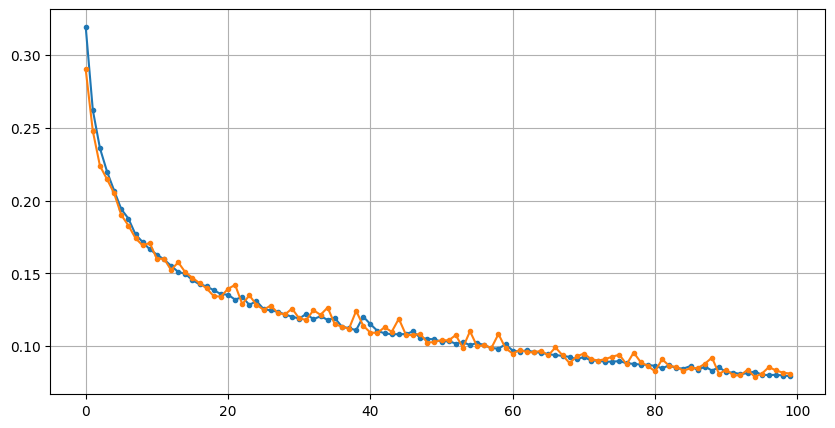

In [15]:
energy_real_train = np.load("data/energy/preprocessed/style_train.npy")
energy_real_test = np.load("data/energy/preprocessed/style_test.npy")

energy_is_train = np.load("data/energy/preprocessed/in_sample_train.npy")
energy_is_test = np.load("data/energy/preprocessed/in_sample_train.npy")

energy_is_model = train_model(energy_is_train, energy_is_test, epochs=100)

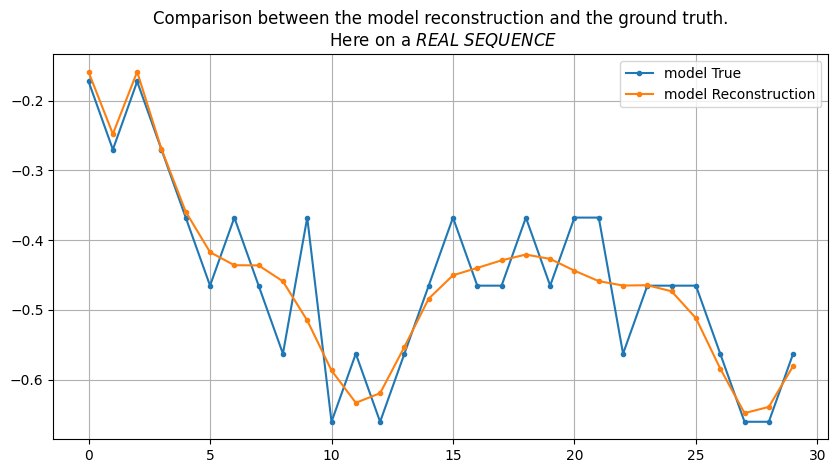

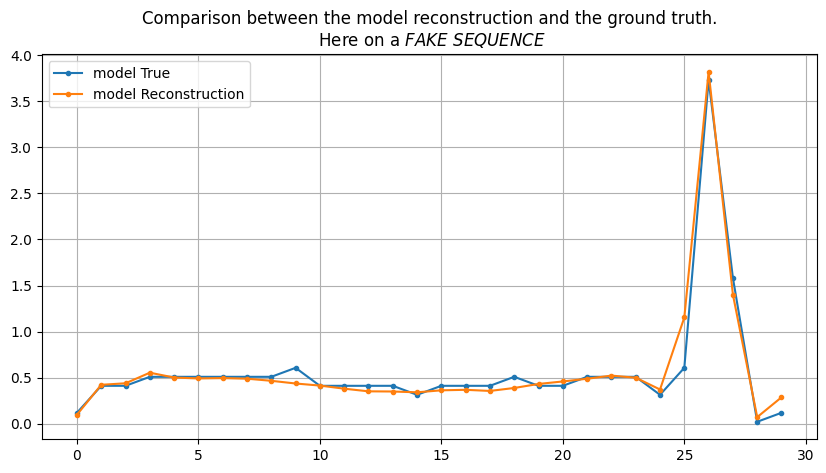

In [ ]:
plot_reconstruction(
    energy_is_model, 
    energy_real_test[0],
    "Comparison between the model reconstruction and the ground truth.\n Here on a $REAL$ $SEQUENCE$"
    )

plot_reconstruction(
    energy_is_model, 
    energy_is_test[0],
    "Comparison between the model reconstruction and the ground truth.\n Here on a $FAKE$ $SEQUENCE$"
    )

### TSTR MAE on "perturbed" dataset.

Epoch 1/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.7799 - mean_absolute_error: 0.9826 - val_loss: 0.5010 - val_mean_absolute_error: 0.5835
Epoch 2/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.4576 - mean_absolute_error: 0.5554 - val_loss: 0.4517 - val_mean_absolute_error: 0.5136
Epoch 3/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.4358 - mean_absolute_error: 0.5034 - val_loss: 0.3918 - val_mean_absolute_error: 0.4798
Epoch 4/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.3917 - mean_absolute_error: 0.4709 - val_loss: 0.4260 - val_mean_absolute_error: 0.4566
Epoch 5/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.3863 - mean_absolute_error: 0.4526 - val_loss: 0.3571 - val_mean_absolute_error: 0.4404
Epoch 6/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.3543 - mean_absolute_error: 0.4351 - val_loss: 0.3624 - val_mean_absolute_error: 0.4258
Epoch 7/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.3513 - mean_absolute_err

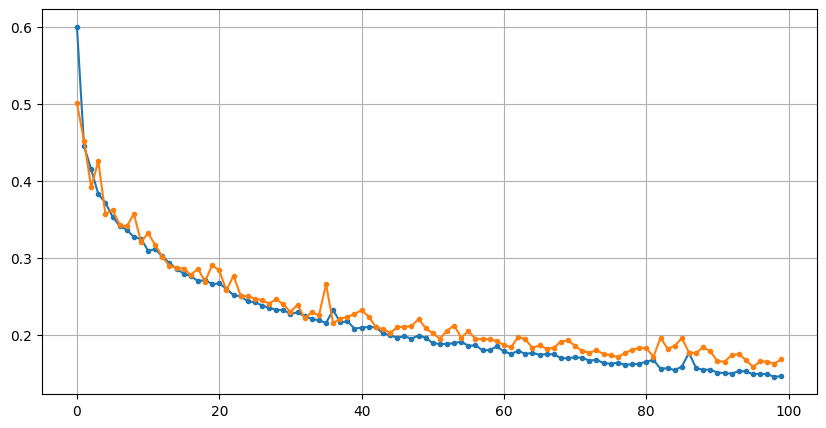

In [ ]:
energy_pert_train = np.load("data/energy/preprocessed/perturbed_train.npy")
energy_pert_test = np.load("data/energy/preprocessed/perturbed_test.npy")

energy_pert_model = train_model(energy_pert_train, energy_pert_test, epochs=100)

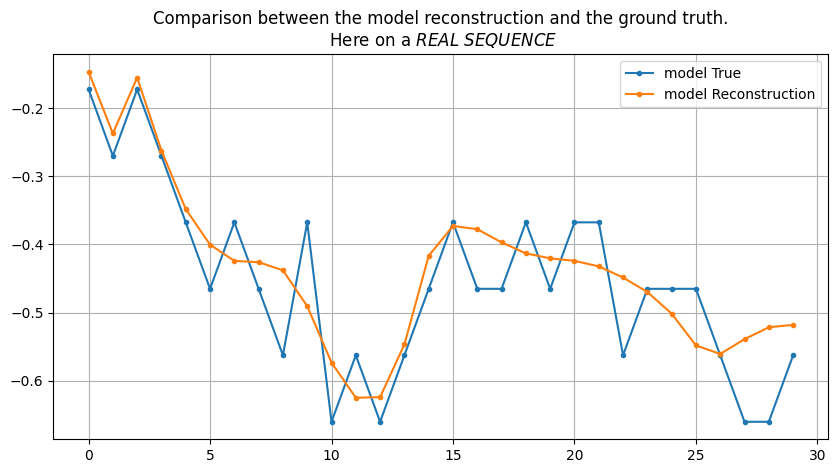

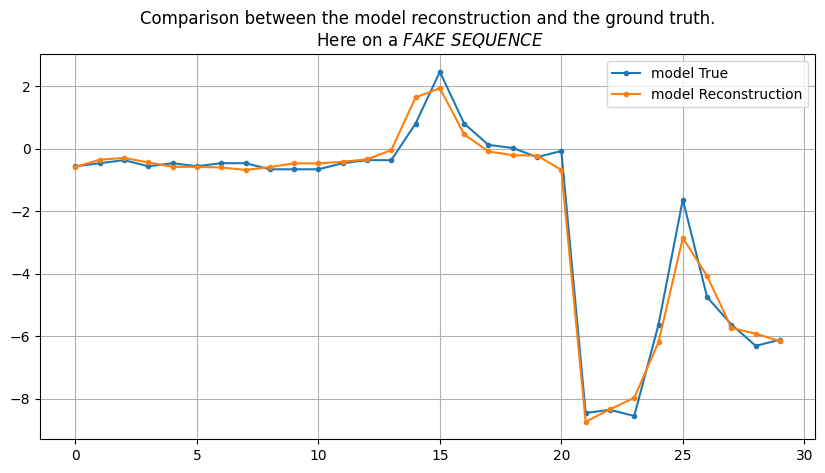

In [ ]:
plot_reconstruction(
    energy_pert_model, 
    energy_real_test[0],
    "Comparison between the model reconstruction and the ground truth.\n Here on a $REAL$ $SEQUENCE$"
    )

plot_reconstruction(
    energy_pert_model, 
    energy_pert_test[0],
    "Comparison between the model reconstruction and the ground truth.\n Here on a $FAKE$ $SEQUENCE$"
    )

### Evaluate the model.

In [ ]:
energy_is_res_on_real = evaluate_model(energy_is_model, energy_real_test)
energy_is_res_on_fake = evaluate_model(energy_is_model, energy_is_test)

energy_is_res_on_real, energy_is_res_on_fake

(np.float32(0.09156267), np.float32(0.08118033))

In [ ]:
energy_pert_res_on_real = evaluate_model(energy_pert_model, energy_real_test)
energy_pert_res_on_fake = evaluate_model(energy_pert_model, energy_pert_test)

energy_pert_res_on_real, energy_pert_res_on_fake

(np.float32(0.2000541), np.float32(0.16845404))

### Make the DataFrame

In [21]:
values = np.array([[energy_is_res_on_real],  [energy_pert_res_on_real]])
# values = 1- values
cols = ["Energy TSTR MAE"]
index = ["Style Time (In Samples)", "Style Time (Perturbed)"]

df_energy_results = pd.DataFrame(index=index, columns=cols, data=values)

df_energy_results

,Energy TSTR MAE
Style Time (In Samples),0.091563
Style Time (Perturbed),0.200054


In [ ]:
google_stocks_results.merge(df_energy_results, left_index=True, right_index=True)

,Google Stocks TSTR MAE,Google Stocks F1,Energy TSTR MAE
Style Time (In Samples),0.016463,0.555823,0.091563
Style Time (Perturbed),0.009335,0.528474,0.200054


# Precisions Recall Metric

We will use autoencoder for the precision recall metrics, because there is no label associated to this dataset

In [ ]:
in_sample_trained_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 30)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 30, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │       150,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 100)        │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 1)          │           101 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 30)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 754,055 (2.88 MB)

 Trainable params: 251,351 (981.84 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 502,704 (1.92 MB)